# store-sales-time-series-forecasting

## Downloading Data Files

In [1]:
# from kaggle.api.kaggle_api_extended import KaggleApi
# api = KaggleApi()
# api.authenticate()
# api.competition_download_files('store-sales-time-series-forecasting')

In [2]:
# import os
# zip_path = os.path.join(os.getcwd(), 'store-sales-time-series-forecasting.zip')
# directory_to_extract_to = os.path.join(os.getcwd(), 'data')

# try:
#     os.makedirs(directory_to_extract_to)
# except FileExistsError:
#     pass

# import zipfile
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

## Importing Required Libraries

In [3]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler

data_path = os.path.join(os.getcwd(), 'data')

## Reading Data Files

In [4]:
def read_csv_files(file_name, path):
    if file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        return pd.read_csv(file_path)
    else:
        raise FileNotFoundError(f'File: {file_name} does not exists in {path}')

In [5]:
train_data = read_csv_files(file_name='train.csv', path=data_path)
test_data = read_csv_files(file_name='test.csv', path=data_path)
oil_data = read_csv_files(file_name='oil.csv', path=data_path)
holiday_data = read_csv_files(file_name='holidays_events.csv', path=data_path)
transactions_data = read_csv_files(file_name='transactions.csv', path=data_path)

## Preprocessing

In [6]:
def make_col_datetime(data_frame, col_name, date_format):
    """
    Converts datetime col to datelike
    """
    df = data_frame.copy()
    try:
        df[col_name] = pd.to_datetime(df[col_name], 
                                      format=date_format, 
                                      errors='raise')
    except ValueError as ve:
        raise ValueError("unable to match date format", ve)
    return df

def drop_col(data_frame, col_name):
    df = data_frame.copy()
    return df.drop(col_name, axis=1)

def set_index(data_frame, col_name):
    df = data_frame.copy()
    return df.set_index(col_name)

def to_categorical(data_frame, col_name):
    df = data_frame.copy()
    
    if not isinstance(col_name, list):
        col_name = [col_name]
    
    for col in col_name:
        df[col] = pd.Categorical(df[col])
    
    return df

In [7]:
train_data = (train_data
 .pipe(make_col_datetime, col_name='date', date_format='%Y-%m-%d')
 .pipe(drop_col, col_name='id')
 .pipe(set_index, col_name='date')
 .pipe(to_categorical, ['store_nbr', 'family'])
)

In [8]:
test_data = (test_data
 .pipe(make_col_datetime, col_name='date', date_format='%Y-%m-%d')
 .pipe(drop_col, col_name='id')
 .pipe(set_index, col_name='date')
 .pipe(to_categorical, ['store_nbr', 'family'])
)

In [9]:
oil_data = (oil_data
 .pipe(make_col_datetime, col_name='date', date_format='%Y-%m-%d')
 .pipe(set_index, col_name='date')
)
oil_data = oil_data.resample('D').mean().fillna(method='ffill').dropna().copy()

In [10]:
holiday_data = (holiday_data
 .pipe(make_col_datetime, col_name='date', date_format='%Y-%m-%d')
)

transactions_data = (transactions_data
 .pipe(make_col_datetime, col_name='date', date_format='%Y-%m-%d')
)

In [11]:
train_data.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0
2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,1,BOOKS,0.0,0


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 4 columns):
 #   Column       Dtype   
---  ------       -----   
 0   store_nbr    category
 1   family       category
 2   sales        float64 
 3   onpromotion  int64   
dtypes: category(2), float64(1), int64(1)
memory usage: 74.4 MB


In [13]:
#Null Value Check
train_data.isna().sum()

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

## Exploratory Data Analysis

In [14]:
family_count = len(train_data['family'].unique())
store_count = len(train_data['store_nbr'].unique())
start_date = train_data.index[0].date()
end_date = train_data.index[-1].date()
days = (end_date - start_date).days
print(f'Number of unique Families are: {family_count}')
print(f'Number of Stores are: {store_count}')
print(f'Train data date range is {start_date} to {end_date}')
print(f'Number of days: {days}')

Number of unique Families are: 33
Number of Stores are: 54
Train data date range is 2013-01-01 to 2017-08-15
Number of days: 1687


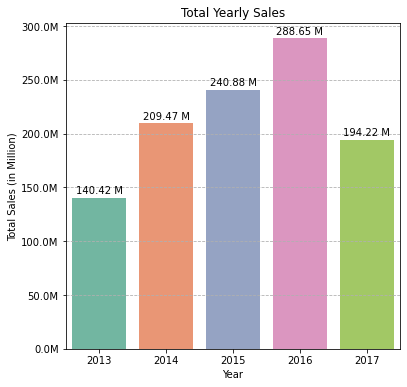

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(data=train_data.groupby([train_data.index.year]).sum(), 
            x=train_data.index.year.unique(), 
            y='sales', 
            palette='Set2', 
            ax=ax)
ax.set_title('Total Yearly Sales')
ax.set_xlabel('Year')
ax.set_ylabel('Total Sales (in Million)')

def formatter(x, pos):
    return str(round(x / 1e6, 0)) + "M"

ax.yaxis.set_major_formatter(formatter)

for b in ax.patches:
    height = round(b.get_height() / 1e6, 2)
    ax.annotate("{:,} M".format(height),
                xy=(b.get_x() + b.get_width() / 2, b.get_height()),
                xytext=(0, 2), # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.grid(axis='y', linestyle='--')

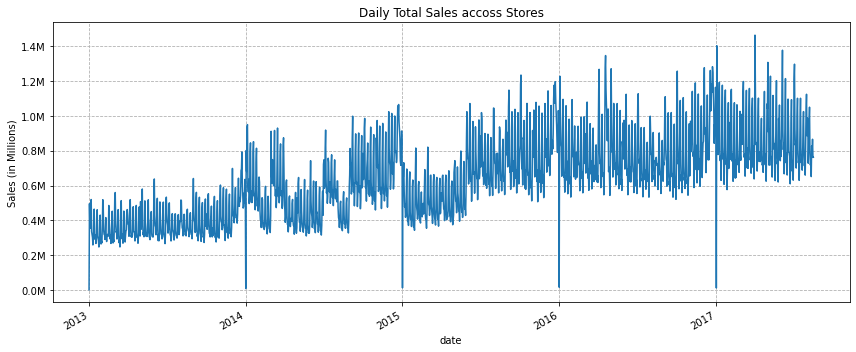

In [16]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

fig, ax = plt.subplots(figsize=(12, 5))
train_data.groupby(train_data.index).sum()['sales'].plot(ax=ax)
plt.ylabel('Sales (in Millions)')
plt.title('Daily Total Sales accoss Stores')
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)
plt.grid(linestyle='--')
plt.tight_layout()
plt.show()

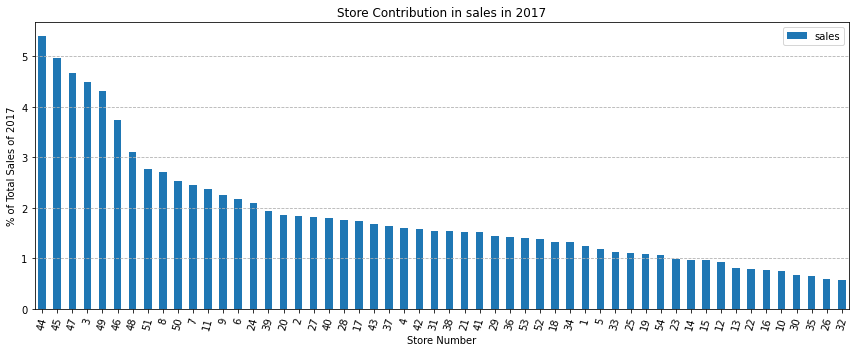

In [17]:
family_sales = (train_data[train_data.index.year == 2017]
                .groupby('store_nbr')
                .agg({'sales': sum})
                .applymap(int)
                .sort_values(by='sales', ascending=False)
               )
contribution = (family_sales / family_sales.sum() *100).round(2)

fig, ax = plt.subplots(figsize=(12, 5))
contribution.plot(kind='bar', ax=ax)
plt.title('Store Contribution in sales in 2017')
plt.ylabel('% of Total Sales of 2017')
plt.xlabel('Store Number')
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

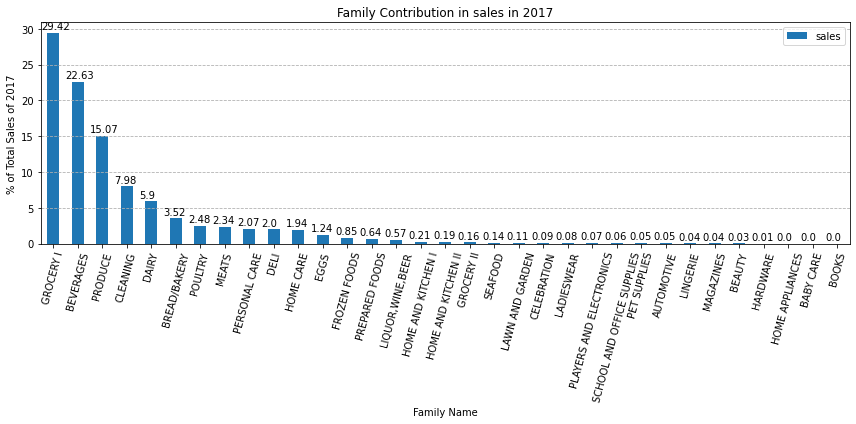

In [18]:
family_sales = (train_data[train_data.index.year == 2017]
                .groupby('family')
                .agg({'sales': sum})
                .applymap(int)
                .sort_values(by='sales', ascending=False)
               )
contribution = (family_sales / family_sales.sum() *100).round(2)

fig, ax = plt.subplots(figsize=(12, 6))
contribution.plot(kind='bar', ax=ax)
plt.title('Family Contribution in sales in 2017')
plt.ylabel('% of Total Sales of 2017')
plt.xlabel('Family Name')

for i, v in enumerate(contribution['sales'].values):
    plt.text(x=i-0.5, y=v+0.5, s=f'{v}')

plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

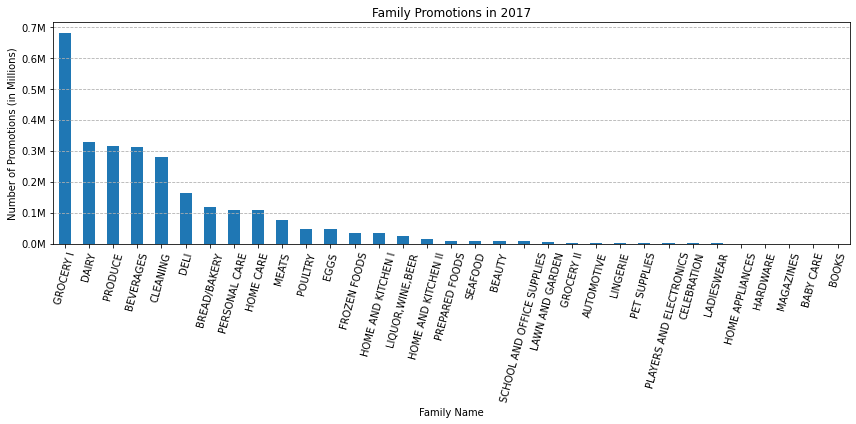

In [19]:
family_sales = (train_data[train_data.index.year == 2017]
                .groupby('family')
                .agg({'onpromotion': sum})
                .applymap(int)
                .sort_values(by='onpromotion', ascending=False)
               )

fig, ax = plt.subplots(figsize=(12, 6))
family_sales['onpromotion'].plot(kind='bar', ax=ax)
plt.title('Family Promotions in 2017')
plt.ylabel('Number of Promotions (in Millions)')
plt.xlabel('Family Name')
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

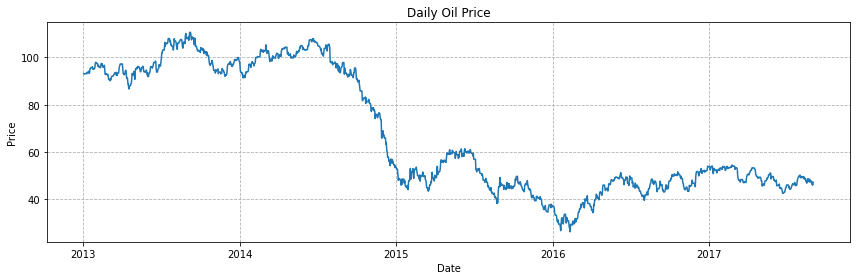

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=oil_data, 
            x=oil_data.index, 
            y='dcoilwtico', 
            ax=ax)
plt.title('Daily Oil Price')
plt.grid(linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

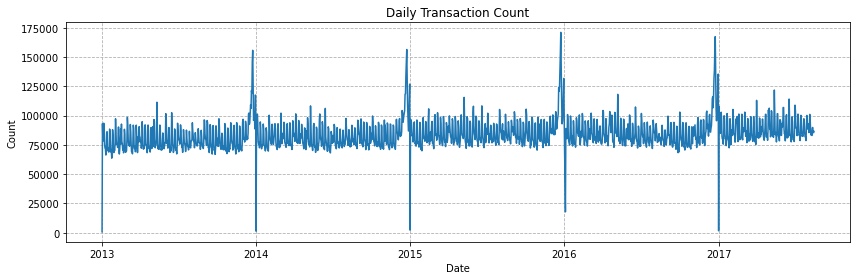

In [21]:
fig, ax = plt.subplots(figsize=(12,4))
df = transactions_data.groupby('date').agg({'transactions': sum})
sns.lineplot(data=df,
             x=df.index,
             y='transactions', 
             ax=ax)
plt.title('Daily Transaction Count')
plt.grid(linestyle='--')
plt.xlabel('Date')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Model Builiding

In [22]:
def make_holiday_dummies(holiday_data):
    holiday_df = holiday_data.copy()
    holiday_df['isholiday'] = 1
    holiday_df = (holiday_df
                  .drop_duplicates(subset=['date', 'description'])
                  .pivot(index='date', columns='description', values='isholiday')
                  .fillna(0)
                  .copy()
                 )
    holiday_df_cols = holiday_df.columns[holiday_df.sum() > 3]
    holiday_df = holiday_df[holiday_df_cols].copy()
    holiday_df.columns = ['holiday ' + col for col in holiday_df.columns]
    return holiday_df

In [23]:
def add_holiday_dummies(data_frame, holiday_data):
    df = data_frame.copy()
    holiday_df = make_holiday_dummies(holiday_data = holiday_data)
    cols = [col for col in holiday_df.columns if col.startswith('holiday')]
    df = pd.merge(df, holiday_df, left_index=True, right_index=True, how='left')
    df[cols] = df[cols].fillna(0)
    return df

In [24]:
import numpy as np

def add_holiday_lags(data_frame, window=1):
    df = data_frame.copy()
    holiday_cols = [col for col in df.columns if col.startswith('holiday') & ('navidad' not in col.lower())]
    
    for col in holiday_cols:
        holiday_dates_in_data = df[df[col] == 1].index
        holiday_lag_dates = []

        for date in holiday_dates_in_data:
            a = np.arange(1, window + 1, 1)
            before = [date - pd.Timedelta(value = x, unit = 'D') for x in a]
            after = [date + pd.Timedelta(value = x, unit = 'D') for x in a]
            holiday_lag_dates += before
            holiday_lag_dates += after
        
        holiday_lag_dates = list(set(holiday_lag_dates) - set(holiday_dates_in_data))
        df[f'window_{window}_{col}'] = [1 if x else 0 for x in df.index.isin(holiday_lag_dates)]
    
    return df

In [25]:
def outlier_analyser(data_dict, target_col, holiday_data, window):
    
    for key in tqdm(data_dict): 
        ts = data_dict.get(key).copy()
        ts_with_holiday_df = add_holiday_dummies(data_frame = ts, holiday_data = holiday_data)
        holiday_cols = [col for col in ts_with_holiday_df.columns if col.startswith('holiday')]
        ts_with_holiday_df['holiday_sum'] = ts_with_holiday_df[holiday_cols].sum(axis=1)
        dates = ts_with_holiday_df[ts_with_holiday_df['holiday_sum'] != 0].index
        h_dates_list = []

        for date in dates:
            h_dates_list.append(date)

            for i in range(1, window + 1):
                prev_date = date - pd.Timedelta(value=i, unit='D')
                next_date = date + pd.Timedelta(value=i, unit='D')
                h_dates_list.append(prev_date)
                h_dates_list.append(next_date)

        h_dates_list = list(set(h_dates_list))  # keeps only unique dates instances
        a = ts_with_holiday_df[~(ts_with_holiday_df.index.isin(h_dates_list))] # removed the holiday dates and window dates
        floor = a[target_col].quantile(0.01) if a[target_col].quantile(0.01) > 0 else 0.0
        cap = a[target_col].quantile(0.98)
        spike_index = a[(a[target_col] < floor) | (a[target_col] > cap)].index

        #updating spikes
        #replaces the outliers with avg value of prev and after dates
        for dt in spike_index:
            before = dt - pd.Timedelta(value=1, unit='D')
            after = dt + pd.Timedelta(value=1, unit='D')
            value = ts[ts.index.isin([before, after])].mean()[target_col]
            ts.loc[dt, target_col] = value

        ts[target_col].clip(lower = floor, 
                            upper=cap, 
                            inplace=True)
        data_dict[key] = ts
    return data_dict

In [26]:
def add_time_exogs(data_frame):
    """
    Adds the columns based on time. columns added are 'year', 'month_1', ... ,'month_11', 
    'week_of_month', 'quarter_1', 'quarter_2', 'quarter_3',
    'day_of_year', 'day_of_week_1', ..., 'day_of_week_6', 'is_weekend'
    
    'year', 'week_of_month', 'day_of_year', 'day_of_month' feature takes values from dates
    remaining columns are dummy variables.
    
    Returns
    -------
    :return: Returns the dataframe of feature added to the original dataframe passed.
    :rtype: DataFrame
    """
    df = data_frame.copy()
    #year feature columns
    df['year'] = df.index.year.values
    df['is_year_start'] = df.index.is_year_start.astype(int)
    df['is_year_end'] = df.index.is_year_end.astype(int)
    
    quarter = df.index.quarter
    for i in range(3): #3columns only #left 4th quarter
        df[f'quarter_{i+1}'] = [1 if x == i+1 else 0 for x in quarter]
    
    #month features columns
    month = (df.index.month).values
    for i in range(11): #11 columns only as 12 columns to make mulicollinearity #dec col left out
        df[f'month_{i+1}'] = [1 if x == i+1 else 0 for x in month]
    
    #week_of_month feature column
    def wm_func(x): return (x.day - 1) // 7 + 1
    week_of_month = [wm_func(x) for x in df.index]
    for i in range(4):
        df[f'week_of_month_{i+1}'] = [1 if x == i+1 else 0 for x in week_of_month]

    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    
    #day_of_year, day_of_week, is_weekend feature column
    df['day_of_month'] = df.index.day
    df['day_of_year'] = df.index.day_of_year

    #day_of_week feature columns
    day_of_week = df.index.day_of_week
    for i in range(6):  # 6columns only as 7 columns to make mulicollinearity #sunday left out
        df[f'day_of_week_{i+1}'] = [1 if x == i else 0 for x in day_of_week]

    #is_weekend feature columns
    _list = [1 if (x == 6 or x == 7) else 0 for x in day_of_week]
    df['is_weekend'] = _list
    
    return df

In [27]:
def add_lag_exogs(data_frame, target_col):
    df = data_frame.copy()
    
    for i in [7, 8]:
        df[f'lag_{target_col}_{i}'] = df[target_col].shift(i)
    
    return df

In [28]:
def zero_demand_count(data_frame, target_col):
    """
    Adds the feature columns with names as 'is_prev_demand_zero', 'number_of_prev_zero_demand_days'.
    'is_prev_demand_zero' - a dummy variable - takes value 1 if demand at t-1 is zero else takes 0.
    'number_of_prev_zero_demand_days' - At time t computes the number of consecutive zero demand days untill time t.
    
    Returns
    -------
    :return: Returns the dataframe of feature added to the original dataframe passed.
    :rtype: DataFrame
    """
    ts = data_frame.copy()
    _list = [1 if x == 0 else 0 for x in ts[target_col]]
    zero_int = []
    zero_int.append(_list[0])
    
    for i in range(1, len(_list)):
        if _list[i] == 0:
            zero_int.append(0)
        else:
            if _list[i-1] == 0:
                zero_int.append(1)
            else:
                _sum = zero_int[-1] + 1
                zero_int.append(_sum)
    
    temp_df = pd.DataFrame(
        {
            'is_prev_demand_zero': _list, 
            'number_of_prev_zero_demand_days': zero_int
        }, 
        index = ts.index
    ).shift(1)
    ts = ts.merge(temp_df, left_index=True, right_index=True, how='left')
    return ts

In [29]:
def preprocess(data_frame):
    df = data_frame.copy()
    prod_dict={}
    
    for store in tqdm(df['store_nbr'].unique()):
        for family in df['family'].unique():
            prod_df = df[(df['store_nbr'] == store) & (df['family'] == family)].copy()
            prod_df.drop(['store_nbr', 'family'], axis=1, inplace=True)
            prod_df = prod_df.resample('D').sum().fillna(0).copy()
            prod_dict[(store, family)] = prod_df
    
    return prod_dict

In [30]:
def generate_exogs(train_data, holiday_data, oil_data, test_exog, batch_size):
    df = train_data.copy()
    oil_df = oil_data.copy()
    test_df = test_exog.copy()
    
    train_exog = add_lag_exogs(data_frame = df, target_col='sales')
    lags_columns = [col for col in train_exog if 'lag' in col]
    
    if batch_size == 1:
        train_exog = zero_demand_count(data_frame = train_exog, target_col='sales')
    
    train_exog = pd.merge(train_exog, oil_df, left_index=True, right_index=True, how='left')
    train_exog = add_holiday_dummies(data_frame = train_exog, holiday_data = holiday_data)
    train_exog = add_time_exogs(data_frame = train_exog)
    train_exog.dropna(inplace=True)
    train_exog.drop('sales', axis=1, inplace=True)
    
    test_exog[lags_columns] = np.nan #make_lags
    
    if batch_size == 1:
        test_exog['is_prev_demand_zero'] = np.nan #zero_demand_count
        test_exog['number_of_prev_zero_demand_days'] = np.nan #zero_demand_count
    
    test_exog = pd.merge(test_exog, oil_df, left_index=True, right_index=True, how='left')
    test_exog = add_holiday_dummies(data_frame = test_exog, holiday_data = holiday_data)
    test_exog = add_time_exogs(data_frame = test_exog)
    
    return [train_exog, test_exog]

In [31]:
import re

def get_null_values(train_endog, train_exogs, forecast_exogs, fcst, horizon):
    cols = forecast_exogs.columns[forecast_exogs.isna().sum() > 0]
    df = pd.concat([train_exogs, forecast_exogs], axis=0)
    all_instances = np.append(train_endog, fcst)
    _dict = {}
    
    for col in cols:
        if 'lag' in col:
            lag = int(re.split("_+", col)[-1])
            _dict[col] = all_instances[-lag:][:horizon]
    
    if horizon == 1:
        # Gives na values of 'is_prev_demand_zero' and 'number_of_prev_zero_demand_days'
        if 'is_prev_demand_zero' in cols:
            val = all_instances[-1]
            is_zero = 1 if val == 0 else 0
            _dict['is_prev_demand_zero'] = is_zero
            last_sum = df['number_of_prev_zero_demand_days'].iloc[-1]

            if is_zero == 0: # is_zero = 0 means previous insatance had demand occurance
                days_count = 0
            elif is_zero == 1:
                days_count = last_sum + is_zero
            _dict['number_of_prev_zero_demand_days'] = days_count
    
    return _dict

In [32]:
def get_time_decayed_weights(df, decay_factor=0.01):
    # exp smoothed weights for recency in regression
    most_recent_date = df.index.max()
    days_before_recent_date = (most_recent_date - df.index).days
    weights = (1 - decay_factor) ** days_before_recent_date.values
    return weights

In [33]:
import pickle
def dump_pickle_file(obj, path, mode):
    with open(path, mode) as filehandler:
        pickle.dump(obj, filehandler)
    filehandler.close()

In [34]:
import datetime
def dump_model_fit(model, product_name):
    today_date = datetime.datetime.now().strftime('%Y-%m-%d')
    directory = os.path.join(os.getcwd(), f"fitted models_{today_date}")
    
    if not os.path.isdir(directory):
        os.makedirs(f"fitted models_{today_date}")
    
    val = len(os.listdir(path=directory)) + 1
    filename=f'model_{val}.sav'
    file_path = os.path.join(directory, filename)
    
    f = open(os.path.join(directory, 'name_encoding.txt'), 'a+')
    f.write(f'\n{product_name} - {filename}; ')
    f.close()
    
    dump_pickle_file(obj=model, path=file_path, mode='wb')

In [35]:
def compute_predictions(model, exog):
    fcst = np.around(model.predict(exog)) # forecast value
    predictions_all = np.array([tree.predict(exog) for tree in model.estimators_]).transpose()
    std_dev = np.array(list(map(np.std, predictions_all)))
    lower = fcst - (2 * std_dev) # lower val of prediction interval
    lower = [0 if x < 0 else x for x in lower]
    lower = np.around(lower)
    upper = np.around(fcst + (2 * std_dev)) # upper val of prediction interval
    return np.transpose([fcst, lower, upper])

In [36]:
def model_rfr(train_endog, train_exogs, forecast_exogs, forecast_horizon, 
              batch_size, product_name, ensembler, verbose, save_model):
    y = train_endog.loc[train_exogs.index].ravel().copy()
    x = train_exogs.copy()

    if verbose:
        print(f'train_exogs shape is {x.shape}')
        print(f'train_endog shape is {y.shape}')
        print(f'forecast_exogs shape is {forecast_exogs.shape}')

    sc = StandardScaler()
    X = sc.fit_transform(x)
    weights = get_time_decayed_weights(df = x)
    
    if ensembler == 'rforest':
        ens_model = RandomForestRegressor(n_estimators=50, max_depth=7)
    elif ensembler == 'extrees':
        ens_model = ExtraTreesRegressor(n_estimators=50, max_depth=9)
        
    ens_model.fit(X, y, sample_weight=weights)
    fcst_rfr = np.array([[0,0,0]])
    remaining_forecast_period = forecast_horizon
    iterator_count = int(np.ceil(forecast_horizon / batch_size))
    
    if save_model:
        dump_model_fit(ens_model, f'{product_name}.sav')
    
    for i in range(iterator_count):
        iterator_horizon = min(batch_size, remaining_forecast_period)

        na_dict = get_null_values(
            train_endog = y,
            train_exogs = x, 
            forecast_exogs = forecast_exogs,
            fcst = fcst_rfr,
            horizon = iterator_horizon
        )

        start = i * batch_size
        stop = (i+1) * batch_size
        null_replace_df = pd.DataFrame(na_dict, index = forecast_exogs.index[start: stop])
        forecast_exogs[null_replace_df.columns] = forecast_exogs[null_replace_df.columns].combine_first(null_replace_df)
        exog = sc.transform(forecast_exogs.iloc[start: stop, :])
        forecasts = compute_predictions(model=ens_model, exog=exog)
        fcst_rfr = np.concatenate([fcst_rfr, forecasts])
        remaining_forecast_period -= iterator_horizon
      
    return fcst_rfr[1:]

In [37]:
def prediction(data_dict, holiday_data, oil_data, test_exog, 
               forecast_horizon, ensembler, verbose, save_model):
    fcst_dict={}
    
    for key in tqdm(data_dict):
        
        if data_dict.get(key)['sales'].iloc[-60:].sum() <= 1:
            model_output = np.zeros((forecast_horizon, 3))
        else:
            try:
                batch_size=7
                train_exogs, forecast_exogs = generate_exogs(train_data = data_dict.get(key), 
                                                             holiday_data = holiday_data,
                                                             oil_data = oil_data,
                                                             test_exog = test_exog.get(key),
                                                             batch_size = batch_size)
                model_output = model_rfr(train_endog = data_dict.get(key)['sales'],
                                           train_exogs = train_exogs,
                                           forecast_exogs = forecast_exogs, 
                                           forecast_horizon = forecast_horizon,
                                           batch_size = batch_size,
                                           product_name = key,
                                           ensembler = ensembler,
                                           verbose = verbose,
                                           save_model = save_model)
                
            except ValueError:
                model_output=None
        
        fcst_dict[key] = pd.DataFrame(model_output, index=forecast_exogs.index, 
                                      columns=['Forecast', 'pi_lower', 'pi_upper'])
        file_path = os.path.join(os.getcwd(), "sales_forecasts.pkl")
        dump_pickle_file(obj=fcst_dict, path=file_path, mode='wb')
    
    return fcst_dict

In [38]:
def pipeline(train_data, test_data, oil_data, holiday_data, 
             forecast_horizon, ensembler, verbose, save_model):
    print('Processing Train Data....')
    train_dict = preprocess(data_frame = train_data)
    print('Processing Test Data....')
    test_onpromotion = preprocess(data_frame = test_data)
    print('Data Processing Complete....')
    print('Starting Outlier Analyser....')
    train_dict = outlier_analyser(data_dict = train_dict, 
                                   target_col='sales', 
                                   holiday_data = holiday_data, 
                                   window=1)
    print('Outlier Analyser Completed....')
    print('Generating Predictions....')
    forecasts = prediction(data_dict = train_dict, 
                           holiday_data = holiday_data, 
                           oil_data = oil_data, 
                           test_exog = test_onpromotion,
                           forecast_horizon = forecast_horizon,
                           ensembler = ensembler,
                           verbose = verbose, 
                           save_model = save_model)
    print('Completed Generating Predictions...')
    return forecasts

## Back Testing of Model

In [39]:
cv_date='2017-08-01'
train_data_cv = train_data[train_data.index < cv_date].copy()
test_data_cv = train_data[train_data.index >= cv_date].copy()
test_data_cv.drop('sales', axis=1, inplace=True)

### extress

In [40]:
forecasts_cv = pipeline(train_data=train_data_cv, 
                        test_data=test_data_cv, 
                        oil_data=oil_data, 
                        holiday_data=holiday_data,
                        forecast_horizon=15,
                        ensembler='extrees',
                        verbose=False,
                        save_model=True)

Processing Train Data....


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:17<00:00,  3.05it/s]


Processing Test Data....


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 17.16it/s]


Data Processing Complete....
Starting Outlier Analyser....


100%|██████████████████████████████████████████████████████████████████████████████| 1782/1782 [01:09<00:00, 25.68it/s]


Outlier Analyser Completed....
Generating Predictions....


100%|██████████████████████████████████████████████████████████████████████████████| 1782/1782 [09:52<00:00,  3.01it/s]

Completed Generating Predictions...


### rforest

In [39]:
forecasts_cv = pipeline(train_data=train_data_cv, 
                        test_data=test_data_cv, 
                        oil_data=oil_data, 
                        holiday_data=holiday_data,
                        forecast_horizon=15,
                        ensembler='rforest',
                        verbose=False,
                        save_model=True)

Processing Train Data....


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.85it/s]


Processing Test Data....


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 16.99it/s]


Data Processing Complete....
Starting Outlier Analyser....


100%|██████████████████████████████████████████████████████████████████████████████| 1782/1782 [01:09<00:00, 25.63it/s]


Outlier Analyser Completed....
Generating Predictions....


100%|██████████████████████████████████████████████████████████████████████████████| 1782/1782 [10:04<00:00,  2.95it/s]

Completed Generating Predictions...


## Accuracy Metric

In [42]:
def wmape_calculator(data_frame, forecast_col, act_col):
    """
    Returns WMAPE in decimal as from = sigma {1 to n} ( wt * |y - yhat|) / sigma {1 to n} (wt * |y|)
    :type weight: dict
    """
    temp_data_frame = data_frame.copy()
    temp_data_frame['abs dev'] = abs(temp_data_frame[forecast_col] - temp_data_frame[act_col])
    temp_data_frame['weight'] = temp_data_frame[act_col] / temp_data_frame[act_col].sum()
    temp_data_frame['num'] = temp_data_frame['weight'] * temp_data_frame['abs dev']
    temp_data_frame['den'] = temp_data_frame['weight'] * abs(temp_data_frame[act_col])
    return temp_data_frame['num'].sum() / temp_data_frame['den'].sum()

### Extress

In [48]:
forecast_data = pd.DataFrame()
forecast_index = pd.date_range(start=cv_date, periods=15, freq='D')

for key in forecasts_cv:
    df = pd.DataFrame({'store_nbr': key[0], 'family': key[1], 'Forecast':forecasts_cv.get(key)['Forecast'].values.copy()}, index=forecast_index)
    forecast_data = pd.concat([forecast_data, df], axis=0)

forecast_data.reset_index(inplace=True)
forecast_data.rename(columns={'index':'date'}, inplace=True)

act_df = train_data[train_data.index >= '2017-08-01'][['store_nbr', 'family', 'sales']].copy()
act_df.reset_index(inplace=True)

df = pd.merge(act_df, forecast_data, how='inner', on=['date', 'store_nbr', 'family']).copy()

val = 1-wmape_calculator(df, 'Forecast', 'sales')
print('Accuracy of Cross Validation Predictions is: {:.2%}'.format(val))

Accuracy of Cross Validation Predictions is: 84.90%


In [49]:
i=1
x_ax=[]
y_ax=[]
for day in df['date'].unique():
    day_df = df[df['date'] == day]
    wmape = wmape_calculator(data_frame = day_df, forecast_col='Forecast', act_col='sales')*100
    accuracy = round(100 - wmape, 2)
    x_ax.append(pd.to_datetime(day).strftime('%Y-%m-%d'))
    y_ax.append(accuracy)

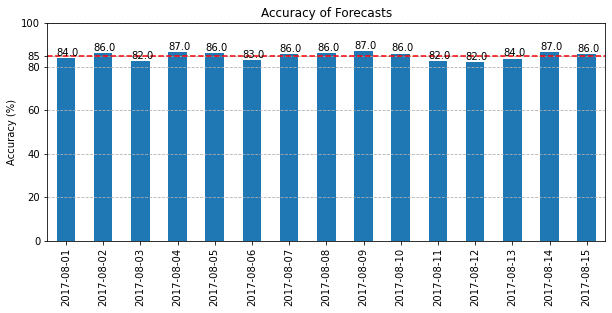

In [50]:
accuracy=pd.Series(y_ax, index=x_ax)
fig, ax = plt.subplots(figsize=(10,4))
accuracy.plot(kind='bar', ax=ax)
plt.axhline(y=round(accuracy.mean()), color='r', linestyle='--')
for i, v in enumerate(accuracy.values):
    plt.text(x=i-0.25 , y =v+1 , s=f"{v.round()}" )
plt.yticks([0, 20, 40, 60, 80, 100, round(accuracy.mean())])
plt.title('Accuracy of Forecasts')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--')
plt.show()

### rforest

In [41]:
forecast_data = pd.DataFrame()
forecast_index = pd.date_range(start=cv_date, periods=15, freq='D')

for key in forecasts_cv:
    df = pd.DataFrame({'store_nbr': key[0], 'family': key[1], 'Forecast':forecasts_cv.get(key).copy()}, index=forecast_index)
    forecast_data = pd.concat([forecast_data, df], axis=0)

forecast_data.reset_index(inplace=True)
forecast_data.rename(columns={'index':'date'}, inplace=True)

act_df = train_data[train_data.index >= '2017-08-01'][['store_nbr', 'family', 'sales']].copy()
act_df.reset_index(inplace=True)

df = pd.merge(act_df, forecast_data, how='inner', on=['date', 'store_nbr', 'family']).copy()

val = 1-wmape_calculator(df, 'Forecast', 'sales')
print('Accuracy of Cross Validation Predictions is: {:.2%}'.format(val))

Accuracy of Cross Validation Predictions is: 85.34%


In [42]:
i=1
x_ax=[]
y_ax=[]
for day in df['date'].unique():
    day_df = df[df['date'] == day]
    wmape = wmape_calculator(data_frame = day_df, forecast_col='Forecast', act_col='sales')*100
    accuracy = round(100 - wmape, 2)
    x_ax.append(pd.to_datetime(day).strftime('%Y-%m-%d'))
    y_ax.append(accuracy)

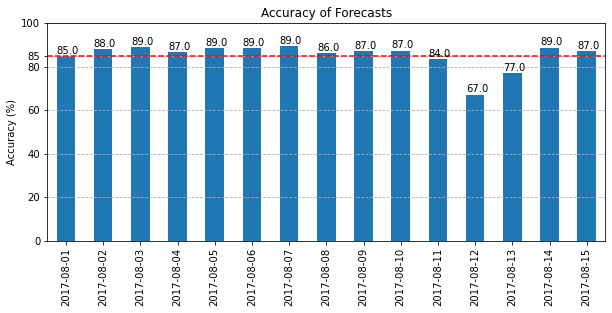

In [43]:
accuracy=pd.Series(y_ax, index=x_ax)
fig, ax = plt.subplots(figsize=(10,4))
accuracy.plot(kind='bar', ax=ax)
plt.axhline(y=round(accuracy.mean()), color='r', linestyle='--')
for i, v in enumerate(accuracy.values):
    plt.text(x=i-0.25 , y =v+1 , s=f"{v.round()}" )
plt.yticks([0, 20, 40, 60, 80, 100, round(accuracy.mean())])
plt.title('Accuracy of Forecasts')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--')
plt.show()